In [29]:
#!pip uninstall torch -y

In [30]:
#%pip cache purge

In [31]:
%pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [32]:
!pip install openai -q

In [33]:
import openai

In [34]:
from getpass import getpass
openai.api_key = getpass()

## OpenAI Whisper

To get started, we'll first install the OpenAI Whisper Python package using pip.

In [35]:
%pip install git+https://github.com/openai/whisper.git -q


Note: you may need to restart the kernel to use updated packages.


We'll also make sure we have a GPU available in Google Colab. If you don't have a GPU, go to Runtime -> Change Runtime Type -> Hardware Accelator and select GPU. I have Colab Pro so I get access to Premium GPU's. Run the command below to show which GPU is being used in the current runtime:

In [36]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-3d950b7d-4623-0f11-ce25-ece7d6375569)


Whisper transcribes audio speech to text. To see this in action, we'll need some audio to operate on. We'll extract some audio from a YouTube video using the pytube Python package. let's install it with pip.

In [37]:
import whisper
from pytube import YouTube

Whisper has a variety of models of varying sizes. The large model will be more accurate but will also be more resource intensive.

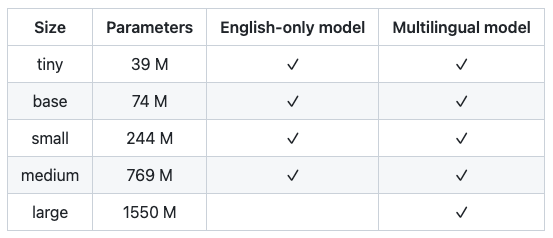

The base model will be sufficient for our needs. Let's load the base model like so:

In [38]:
model = whisper.load_model('medium.en', device='cuda')

In [52]:
import datetime


def tran_file(file_path):
    # save a timestamp before transcription
    t1 = datetime.datetime.now()
    print(f"started at {t1}")

    # do the transcription

    output = model.transcribe(file_path, language='English') #fed_meeting_trimmed.mp4")

    # show time elapsed after transcription is complete.
    t2 = datetime.datetime.now()
    print(f"ended at {t2}")
    print(f"time elapsed: {t2 - t1}")
    return output

In [53]:

def openaiCreate(prompt,maxtokens):
    response =  openai.Completion.create(
        engine="text-davinci-003", 
        prompt=prompt,
        temperature=0.7, # The temperature controls the randomness of the response, represented as a range from 0 to 1. A lower value of temperature means the API will respond with the first thing that the model sees; a higher value means the model evaluates possible responses that could fit into the context before spitting out the result.
        max_tokens=maxtokens,
        top_p=1, # Top P controls how many random results the model should consider for completion, as suggested by the temperature dial, thus determining the scope of randomness. Top P’s range is from 0 to 1. A lower value limits creativity, while a higher value expands its horizons.
        frequency_penalty=0,
        presence_penalty=1
    )
    response_text = response["choices"][0]["text"]+'\n\n'
    return response_text

In [57]:
import time

def tryresponse(prompt,maxtokens,failcount=0):
    summary_responses = []
    # Loop until the number of failed attempts is less than 4
    while failcount < 4:
        try:
            # Make an OpenAI API request with the given prompt and maximum tokens
            response_text = openaiCreate(prompt, maxtokens)
        except openai.error.APIError as e:
            # Handle API errors
            print(f"OpenAI API returned an API Error: {e}")
            failcount = failcount + 1
            # Increase waiting time before trying again
            time.sleep(5^failcount)
            # Recursively call the function again with updated failcount
            response_text = tryresponse(prompt, maxtokens, failcount)
            pass
        except openai.error.APIConnectionError as e:
            # Handle connection errors
            print(f"Failed to connect to OpenAI API: {e}")
            failcount = failcount + 1
            # Increase waiting time before trying again
            time.sleep(5^failcount)
            # Recursively call the function again with updated failcount
            response_text = tryresponse(prompt, maxtokens, failcount)
            pass
        except openai.error.RateLimitError as e:
            # Handle rate limit errors
            print(f"OpenAI API request exceeded rate limit: {e}")
            failcount = failcount + 1
            # Increase waiting time before trying again
            time.sleep(5^failcount)
            # Recursively call the function again with updated failcount
            response_text = tryresponse(prompt, maxtokens, failcount)
            pass
                
        # If the request is successful, append the response text to the summary_responses list
        #summary_responses.append(response_text)

        # Return the list of response texts
        #return summary_responses
        return response_text


In [58]:
import numpy as np
import math

def summarize(fulltext,maxtokens = 150,hint='\n\ntl;dr:'):
    # split the full text into words
    words = fulltext.split(" ")

    # calculate number of segments as the floor of the length of words divided by 2500
    n = math.floor(len(words)/2500)
    # if number of segments is less than 1, set it to 1
    numsegments = n if n > 1 else 1

    # split words into chunks based on the number of segments
    chunks = np.array_split(words, numsegments)

    # initialize an empty list to store summary responses
    summary_responses = []

    # loop through each chunk
    for chunk in chunks:
        # join words in the chunk back into a string separated by spaces
        paragraphs = ' '.join(list(chunk))

        # create the prompt by adding the hint to the joined chunk
        prompt = f"{paragraphs}{hint}"

        # generate response text using the prompt
        response_text = tryresponse(prompt,maxtokens)
        # append the response text to the list of summary responses
        summary_responses.append(response_text)

    # join all the summary responses into a single string
    full_summary = "".join(summary_responses)

    # return the full summary
    return full_summary

    

In [63]:
import os


def transcribe_audio_subfiles(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.
            if filepath.endswith(".m4a"):
                print (filepath)
                if os.path.isfile(root+"\\transcription.txt"):
                    readfile = open(root+"\\transcription.txt",'r') 
                    fulltext = readfile.read()
                    readfile.close()
                else:     
                    output = tran_file(filepath)
                    fulltext = output['text']  
                    with open(root+"\\transcription.txt",'w+') as file:
                            file.write(fulltext)
                            file.close()
                
                if os.path.isfile(root+"\\summary.txt"):
                    readfile = open(root+"\\summary.txt",'r') 
                    full_summary = readfile.read()
                    readfile.close()
                else:
                    full_summary = summarize(fulltext)
                                       
                    with open(root+"\\summary.txt",'w+') as file2:
                        file2.write(full_summary)
                        file2.close()

                if os.path.isfile(root+"\\short.txt"):
                    readfile = open(root+"\\short.txt",'r') 
                    full_short = readfile.read()
                    readfile.close()
                else:
                    full_short = summarize(full_summary)
                                       
                    with open(root+"\\short.txt",'w+') as file2:
                        file2.write(full_short)
                        file2.close() 

                full_title = summarize('OCCRA Board of Directors Meeting notes:\n\n'+full_summary,25,'\n\nThe 150 character title of this document should be (with no special characters):')
                                    
                with open(root+"\\title.txt",'w+') as file2:
                    file2.write(full_title)
                    file2.close() 

    return file_paths  # Self-explanatory.

# Run the above function and store its results in a variable.   
full_file_paths = transcribe_audio_subfiles("D:\Zoom\Zoom")

D:\Zoom\Zoom\2020-04-24 20.16.42 Cole Williams' Personal Meeting Room 6149609914\audio_only.m4a
D:\Zoom\Zoom\2020-05-12 20.11.56 Cole Williams' Zoom Meeting 85698491966\audio_only.m4a
D:\Zoom\Zoom\2020-05-14 20.22.07 Cole Williams' Zoom Meeting 83830817766\audio_only.m4a
D:\Zoom\Zoom\2020-05-18 20.08.39 Cole Williams' Zoom Meeting 84622214214\audio_only.m4a
D:\Zoom\Zoom\2020-05-18 20.38.17 Cole Williams' Zoom Meeting 84622214214\audio_only.m4a
D:\Zoom\Zoom\2020-05-19 20.13.54 Cole Williams' Zoom Meeting 82049874782\audio_only.m4a
D:\Zoom\Zoom\2020-05-20 20.09.39 Cole Williams' Zoom Meeting 89233474290\audio_only.m4a
D:\Zoom\Zoom\2020-06-01 20.11.57 Cole Williams' Zoom Meeting 84312692725\audio_only.m4a
D:\Zoom\Zoom\2020-08-24 20.10.39 OCCRA BOD meeting 8_24_20 81748736908\audio_only.m4a
D:\Zoom\Zoom\2020-09-21 20.08.16 OCCRA BoD meeting 85377985456\audio_only.m4a
D:\Zoom\Zoom\2020-10-12 20.10.50 Cole Williams' Personal Meeting Room 6149609914\audio_only.m4a
D:\Zoom\Zoom\2020-11-09 20.0